In [1]:
import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

import pickle5 as pickle
from tqdm.notebook import tqdm

In [2]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [3]:
state_space = env.observation_space.n
action_space = env.action_space.n

In [4]:
Q_table = np.zeros((state_space,action_space))

In [5]:
# Training parameters
n_training_episodes = 25000  # Total training episodes
learning_rate = 0.7  # Learning rate

# Evaluation parameters
n_eval_episodes = 100  # Total number of test episodes

# DO NOT MODIFY EVAL_SEED
eval_seed = [
    16,
    54,
    165,
    177,
    191,
    191,
    120,
    80,
    149,
    178,
    48,
    38,
    6,
    125,
    174,
    73,
    50,
    172,
    100,
    148,
    146,
    6,
    25,
    40,
    68,
    148,
    49,
    167,
    9,
    97,
    164,
    176,
    61,
    7,
    54,
    55,
    161,
    131,
    184,
    51,
    170,
    12,
    120,
    113,
    95,
    126,
    51,
    98,
    36,
    135,
    54,
    82,
    45,
    95,
    89,
    59,
    95,
    124,
    9,
    113,
    58,
    85,
    51,
    134,
    121,
    169,
    105,
    21,
    30,
    11,
    50,
    65,
    12,
    43,
    82,
    145,
    152,
    97,
    106,
    55,
    31,
    85,
    38,
    112,
    102,
    168,
    123,
    97,
    21,
    83,
    158,
    26,
    80,
    63,
    5,
    81,
    32,
    11,
    28,
    148,
]  # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
# Each seed has a specific starting state

# Environment parameters
env_id = "Taxi-v3"  # Name of the environment
max_steps = 99  # Max steps per episode
gamma = 0.95  # Discounting rate

# Exploration parameters
max_epsilon = 1.0  # Exploration probability at start
min_epsilon = 0.05  # Minimum exploration probability
decay_rate = 0.005  # Exponential decay rate for exploration prob

In [6]:
def greedy_policy(Qtable,state):
    action = np.argmax(Qtable[state][:])
    return action

In [7]:
def epsilon_greedy_policy(Qtable,state,epsilon):
    random_num = random.uniform(0,1)
    if random_num > epsilon:
        action = greedy_policy(Q_table,state)
    else:
        action = env.action_space.sample()
    return action

  0%|          | 0/25000 [00:00<?, ?it/s]

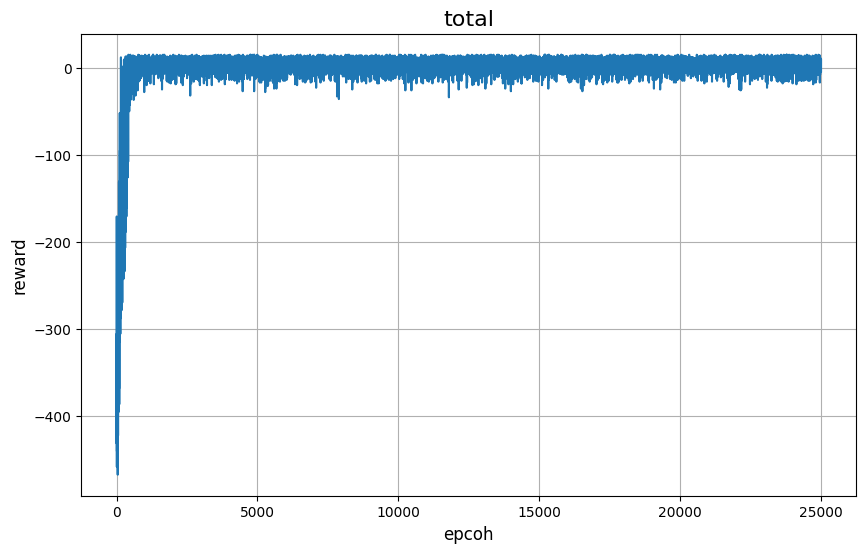

In [8]:
# 引入绘图库
import matplotlib.pyplot as plt
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    # 新增：创建一个空列表来存储每个回合的总奖励
    episode_rewards = []
    
    for episode in tqdm(range(n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
        state, info = env.reset()
        
        # 新增：用于记录当前回合总奖励的变量
        total_reward = 0
        
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, terminated, truncated, info = env.step(action)
            
            Qtable[state][action] = Qtable[state][action] + learning_rate*(reward + gamma * max(Qtable[new_state]) -Qtable[state][action])
            
            # 新增：累加当前回合获得的奖励
            total_reward += reward
            
            if truncated or terminated:
                break
            state = new_state
            
        # 新增：将当前回合的总奖励添加到列表中
        episode_rewards.append(total_reward)

    # 训练结束后返回 Q-table 和奖励列表
    return Qtable, episode_rewards

# 调用修改后的训练函数
Qtable_frozenlake, rewards_per_episode  = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Q_table)

# 新增：绘制奖励折线图
plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode)
plt.title("total", fontsize=16)
plt.xlabel("epcoh", fontsize=12)
plt.ylabel("reward", fontsize=12)
plt.grid(True)
plt.show()

In [9]:
def evaluate_agent_and_render(env, max_steps, Q, seed, gif_path="frozenlake.gif"):
    frames = []
    episode_rewards = []
    
    # 我们只录制一个回合的视频，所以 n_eval_episodes 设为 1
    n_eval_episodes = 1 
    
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        
        terminated = False
        truncated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # 渲染并捕获当前帧
            frame = env.render()
            if frame is not None:
                frames.append(frame)

            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
            
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    # 将捕获的帧保存为 GIF
    imageio.mimsave(gif_path, frames, fps=10)
    print(f"GIF saved to {gif_path}")

    return mean_reward, std_reward

# 调用修改后的评估函数，并传入文件名
mean_reward, std_reward = evaluate_agent_and_render(env, max_steps, Qtable_frozenlake, eval_seed, gif_path="frozenlake_trained_agent.gif")

print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

# 也可以录制一个随机智能体的视频作为对比
# 重新创建一个未训练的Q表
Q_table_random = np.zeros((state_space,action_space)) 
# 设置一个高的epsilon来模拟随机行为
def random_policy(Qtable, state):
    return env.action_space.sample()

# 临时修改贪婪策略，让其随机选择
def temp_greedy_policy_for_random(Qtable, state):
    return random_policy(Qtable, state)
# 暂时替换掉 evaluate_agent_and_render 函数中的贪婪策略
old_greedy_policy = greedy_policy
greedy_policy = temp_greedy_policy_for_random

evaluate_agent_and_render(env, max_steps, Q_table_random, eval_seed, gif_path="frozenlake_random_agent.gif")

# 恢复原来的贪婪策略
greedy_policy = old_greedy_policy

  0%|          | 0/1 [00:00<?, ?it/s]

GIF saved to frozenlake_trained_agent.gif
Mean_reward=6.00 +/- 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

GIF saved to frozenlake_random_agent.gif
